# Summary

Explore derivation of Lagrangian. 

Currently this is achieved by forcing $p_z = -1/\xi^{\downarrow_0} = \mathrm{constant}$, which seems a bit heavy-handed (although it's a natural consequence of $\varphi$ being independent of $r^z$).
We also required $\eta=\tfrac{1}{2}$. Problems arise with $\eta=\tfrac{3}{2}$, because a simple relationship between $\tan\beta$ and $\tan\alpha$ is not easy to derive.

### Preliminaries

In [1]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np, os
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, expand, factor, collect, \
    Rational, Eq, solve, sqrt, cbrt, Matrix, diff, pi, \
    poly, lambdify, N, numer, denom, trigsimp, Abs, \
    sin, cos, tan, atan
from scipy.optimize import root_scalar

# Import Geomorphysics library functions
from gmplib.utils import e2d

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations

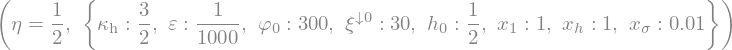

In [2]:
eta_ = Rational(1,2)
sub = {
        x_1: 1, 
        varepsilon: Rational(1,1000), 
        varphi_0: 300,
        xiv_0: 30,
        kappa_h: Rational(3,2),
        h_0: Rational(1,2),
        x_sigma: 0.01,
        x_h: 1
}
Eq(eta,eta_), sub

# Recap of Hamiltonian, front and ray angles

In [3]:
gmeq = Equations(eta=eta_)

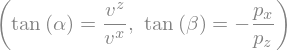

In [4]:
gmeq.tanalpha_rdot_eqn, gmeq.tanbeta_pxpz_eqn

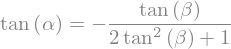

In [5]:
gmeq.tanalpha_beta_eqn

In [6]:
gmeq.tanbeta_alpha_eqn

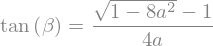

In [7]:
tanbeta_eqn = gmeq.tanbeta_alpha_eqns[0].subs({tan(alpha):ta})
tanbeta_eqn

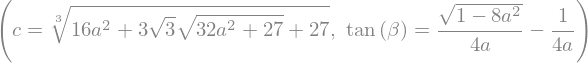

In [8]:
c_a_eqn = Eq(c,((16*ta**2+3*sqrt(3)*sqrt((32*ta**2+27))+27)**Rational(1,3)) )
tanbeta_c_a_eqn = Eq(tanbeta_eqn.lhs, expand(tanbeta_eqn.rhs.subs({c_a_eqn.rhs:c})) )
c_a_eqn, tanbeta_c_a_eqn

# Find an on-shell point in T*M

To test our derivations, at minimum we need a point in slowness phase space that is on-shell, along with its counterpart in velocity phase space. We start with setting some model constants.

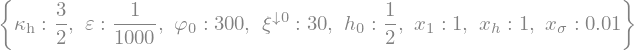

In [9]:
sub

Let's arbitrarily choose $x=0$, as if we were choosing a viable boundary condition. We first need the erosion rate $\xi(0)$:

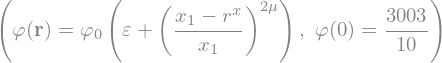

In [10]:
varphi_ = gmeq.varphi_rx_eqn.rhs.subs(sub).subs({rx:0})
gmeq.varphi_rx_eqn, Eq(varphi_rx.subs({rx:0}),varphi_)

From the erosion model, derive an equation in terms of $p_x$, $u^\downarrow$ and $\xi$ only:

In [11]:
# gmeq.px_pz_xi_varphi_eqn
gmeq.px_xiv_varphi_eqn

In [12]:
# px_varphi_xiv_eqn = simplify( Eq( gmeq.xiv_varphi_pxpz_eqn.lhs**2/xiv**2,
#                                     gmeq.xiv_varphi_pxpz_eqn.rhs**2/xiv**2) )
# expand(px_varphi_xiv_eqn), expand(px_varphi_xiv_eqn).subs({varphi_r:varphi_})

and convert into a polynomial in $p_x$ for the chosen point:

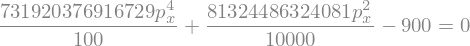

In [13]:
px_eqn = gmeq.px_xiv_varphi_eqn.subs({varphi_r:varphi_})\
                    .subs({xiv:xiv_0}).subs(sub)
px_eqn

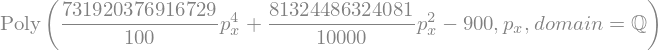

In [14]:
px0_poly_eqn = poly(px_eqn)
px0_poly_eqn

Find the value of $p_x$ at this point $x=0$:

In [15]:
px0_poly_lambda = lambdify( [px], px0_poly_eqn.as_expr() )
dpx0_poly_lambda = lambdify( [px], diff(px0_poly_eqn.as_expr(),px) )
px0_root_search = root_scalar( px0_poly_lambda, fprime=dpx0_poly_lambda,
                               method='newton', x0=0.01 )
px_ = px0_root_search.root
pz_ = -1/xiv_0.subs(sub)
Eq((px,pz),(px_,sy.N(pz_)))

and use Hamilton's equations to find the ray velocity $\mathbf{v}=\mathbf{\dot{r}}$:

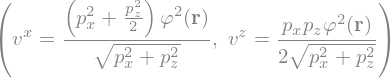

In [16]:
gmeq.rdotx_pxpz_eqn, gmeq.rdotz_pxpz_eqn

In [17]:
gmeq.rdotx_pxpz_eqn.subs({px:px_,pz:pz_}), gmeq.rdotz_pxpz_eqn.subs({px:px_,pz:pz_})

In [18]:
vx_ = gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
vz_ = gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
Eq(rdotx,vx_), Eq(rdotz,vz_)

and compute the corresponding surface tilt $\beta$ and ray angle $\alpha$:

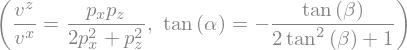

In [19]:
(gmeq.rdotz_on_rdotx_eqn, gmeq.tanalpha_beta_eqn)

In [20]:
gmeq.tanalpha_rdot_eqn.subs({rdotx:vx_, rdotz:vz_})

In [21]:
tanbeta_ = gmeq.tanbeta_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
# tanalpha_ = gmeq.tanalpha_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
tanalpha_ = gmeq.tanalpha_beta_eqn.rhs.subs({tan(beta):tanbeta_})
Eq(tan(beta),tanbeta_), Eq(tan(alpha),tanalpha_)

In [22]:
Eq(beta,N(atan(tanbeta_)*180/pi)), Eq(alpha,N(atan(tanalpha_)*180/pi))

# Lagrangian $L=\frac{1}{2}F^2$  via Legendre transform

Recall the Hamiltonian:

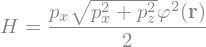

In [23]:
gmeq.H_eqn

and perform the Legendre transform to get the Lagrangian, albeit in T*M coordinates:

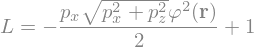

In [24]:
L_eqn = simplify(expand((Eq(L, 1-H).subs({H: gmeq.H_eqn.rhs}))))
L_eqn

Recall the ray velocity vector components obtained from Hamilton's equations:

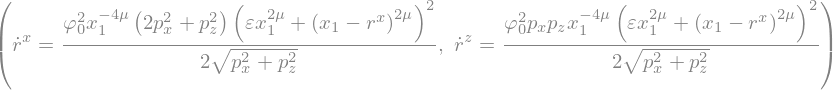

In [25]:
gmeq.hamiltons_eqns[0], gmeq.hamiltons_eqns[1]

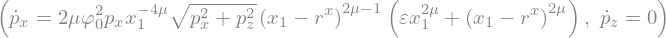

In [26]:
gmeq.hamiltons_eqns[2], gmeq.hamiltons_eqns[3]

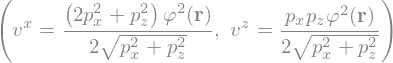

In [27]:
vx_eqn = factor(gmeq.rdotx_pxpz_eqn)
vz_eqn = gmeq.rdotz_pxpz_eqn
vx_eqn, vz_eqn

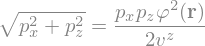

In [28]:
p_px_pz_vz_eqn = Eq(sqrt(px**2+pz**2), solve(vz_eqn, sqrt(px**2+pz**2))[0])
p_px_pz_vz_eqn

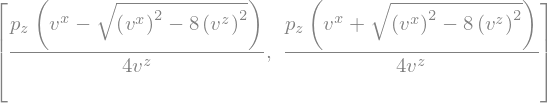

In [29]:
solve(vx_eqn.subs(e2d(p_px_pz_vz_eqn)),px)

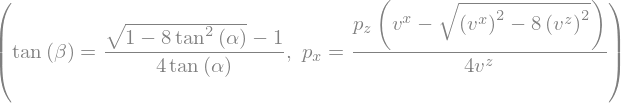

In [30]:
px_pz_vx_vz_eqn = Eq(px, solve( gmeq.tanbeta_alpha_eqns[0]
                            .subs(e2d(gmeq.tanalpha_rdot_eqn))
                            .subs(e2d(gmeq.tanbeta_pxpz_eqn)), px)[0])
gmeq.tanbeta_alpha_eqns[0], px_pz_vx_vz_eqn

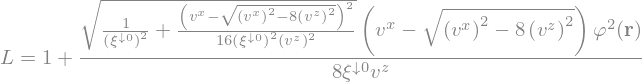

In [31]:
L_simple_eqn = (
    L_eqn.subs(e2d(px_pz_vx_vz_eqn)).subs({pz:pz_0}).subs(e2d(gmeq.pz0_xiv0_eqn))
)
L_simple_eqn

In [32]:
L_simple_eqn.subs({tan(beta):tanbeta_, rdotx:vx_, 
                rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub)

# Lagrangian $L=\frac{1}{2}F^2$ from metric tensor

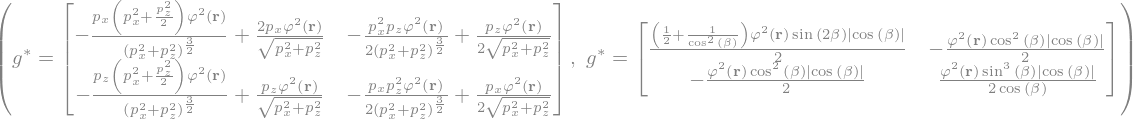

In [33]:
gstar_tanbeta_eqn = simplify( gmeq.gstar_varphi_pxpz_eqn
                             .subs({gmeq.px_pz_tanbeta_eqn.lhs:gmeq.px_pz_tanbeta_eqn.rhs}) )
gmeq.gstar_varphi_pxpz_eqn, gstar_tanbeta_eqn

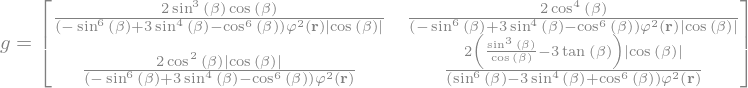

In [34]:
g_xi_tanbeta_eqn = Eq(g, simplify(gstar_tanbeta_eqn.rhs.inverse()))
g_xi_tanbeta_eqn

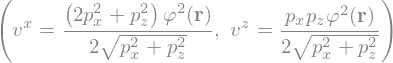

In [35]:
factor(gmeq.rdotx_pxpz_eqn), gmeq.rdotz_pxpz_eqn

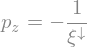

In [36]:
xiv_pz_eqn = Eq(xiv, -1/pz)
pz_xiv_eqn = Eq(pz, solve(xiv_pz_eqn,pz)[0])
pz_xiv_eqn

The following equation ONLY works along geodesics, i.e., ray trajectories.

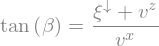

In [37]:
tanbeta_rdotxz_pz_eqn = Eq(tan(beta), (rdotz - 1/pz)/rdotx )
tanbeta_rdotxz_xiv_eqn = tanbeta_rdotxz_pz_eqn.subs({pz:pz_xiv_eqn.rhs})
tanbeta_rdotxz_xiv_eqn

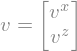

In [38]:
rdot_def_eqn = Eq(rdot_vec, Matrix([rdotx, rdotz]))
rdot_def_eqn

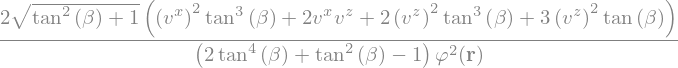

In [39]:
simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
     .subs({Abs(cos(beta)):cos(beta)})
     .subs({sin(beta):tan(beta)*cos(beta)})
     .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
).subs({cos(beta):1/sqrt(1+tan(beta)**2)})

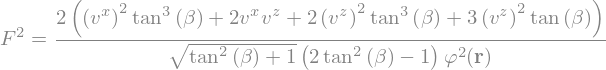

In [40]:
Fsqrd_rdotxz_tanbeta_eqn = Eq(F**2,
    factor(simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
         .subs({Abs(cos(beta)):cos(beta)})
         .subs({sin(beta):tan(beta)*cos(beta)})
         .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
    ).subs({sin(beta):sqrt(1-cos(beta)**2)}).subs({cos(beta):1/sqrt(1+tan(beta)**2)}))
                             )
Fsqrd_rdotxz_tanbeta_eqn

In [41]:
Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tanbeta_, 
                    rdotx:vx_, rdotz:vz_, varphi_r:varphi_}).subs(sub)

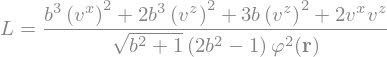

In [42]:
Eq(L, (Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tb}).rhs/2) )

In [53]:
float(sy.deg(atan(eta_)))

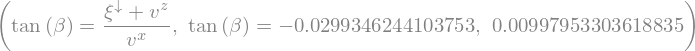

In [43]:
tanbeta_rdotxz_xiv_eqn, tanbeta_rdotxz_xiv_eqn \
                                .subs({xiv:-xiv_0, rdotx:vx_, rdotz:vz_}) \
                                .subs(sub), tanbeta_

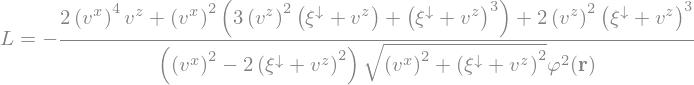

In [44]:
L_rdotxz_xiv_eqn = Eq( L, (simplify( (Fsqrd_rdotxz_tanbeta_eqn.rhs/2)
                                  .subs({tan(beta):tanbeta_rdotxz_xiv_eqn.rhs}))) )
L_rdotxz_xiv_eqn

In [45]:
L_rdotxz_xiv_eqn.subs({tan(beta):tanbeta_, rdotx:vx_, rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub)

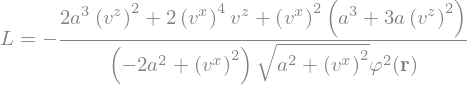

In [46]:
(L_rdotxz_xiv_eqn.subs({xiv+rdotz:ta}))